In [23]:
import pandas as pd
import numpy as np

from pgmpy.models import BayesianNetwork

from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.base import DAG


from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score
from pgmpy.estimators import BDeuScore
from pgmpy.estimators import BicScore
from pgmpy.estimators import AICScore

import networkx as nx
import matplotlib.pyplot as plt

In [7]:
train_df = pd.read_csv('./Data/cardiovascular_train.csv')
nodes = set(train_df.columns)

In [47]:
root_nodes = ['Age', 'Sex']
impossible_connections = []

for root_node in root_nodes:
    for node in nodes:
        connection = (node, root_node)
        impossible_connections.append(connection)

In [14]:
blacklist = set(impossible_connections)

In [15]:
def initialize_graph(nodes,p=1):
  G = DAG()
  G.add_nodes_from(nodes=nodes)
  init = G.get_random(n_nodes=len(nodes), edge_prob=p)
  ls = []
  mapping = {}
  for k in range(len(nodes)):
      mapping[k] = nodes[k]
  for i,j in init.edges:
    ls.append((mapping[i],mapping[j]))
  ls
  G.add_edges_from(ebunch=ls) # G is the required initialization for the Hill Climbing method
  return G

In [ ]:
score_metric = BDeuScore(train_df)
es = HillClimbSearch(train_df)

In [41]:
import random

rand_list = [random.randrange(3, 7) for _ in range(0,15)]
rand_list = [x/10 for x in rand_list]

[0.5, 0.6, 0.5, 0.6, 0.6, 0.6, 0.6, 0.4, 0.6, 0.5, 0.5, 0.4, 0.6, 0.3, 0.5]

In [45]:
current_model = es.estimate(scoring_method=score_metric, black_list=blacklist, start_dag=initialize_graph(nodes=list(nodes), p=0.4))
model_eval = score_metric.score(current_model)

  0%|          | 39/1000000 [00:01<7:25:25, 37.42it/s]


In [43]:
best_eval = 0
for x, y in zip(range(0,15), rand_list):
    current_model = es.estimate(scoring_method=score_metric, black_list=blacklist, start_dag=initialize_graph(nodes=list(nodes), p=y))
    curr_eval = score_metric.score(current_model)
    print(curr_eval)
    if curr_eval > best_eval:
        best_eval = curr_eval
        best_model = current_model

print(best_eval)

  0%|          | 53/1000000 [00:01<6:58:33, 39.82it/s] 


-31658.383216774913


  0%|          | 46/1000000 [00:01<7:26:33, 37.32it/s] 


-31606.87164955897


  0%|          | 40/1000000 [00:01<7:54:16, 35.14it/s]


-31622.119108197712


  0%|          | 45/1000000 [00:01<7:37:54, 36.40it/s] 


-31619.88757663969


  0%|          | 44/1000000 [00:01<7:31:04, 36.95it/s] 


-31619.14345528774


  0%|          | 47/1000000 [00:01<7:19:21, 37.93it/s]


-31568.521003127924


  0%|          | 48/1000000 [00:01<7:23:18, 37.59it/s] 


-31606.812043087273


  0%|          | 33/1000000 [00:00<8:05:47, 34.31it/s]


-31568.894481729014


  0%|          | 46/1000000 [00:01<7:41:00, 36.15it/s]


-31676.44019584953


  0%|          | 45/1000000 [00:01<6:36:46, 42.00it/s] 


-31656.858752892305


  0%|          | 38/1000000 [00:01<7:44:49, 35.85it/s] 


-31539.21451298864


  0%|          | 34/1000000 [00:00<8:00:33, 34.68it/s]


-31635.20578454102


  0%|          | 49/1000000 [00:01<7:20:13, 37.86it/s] 


-31659.198824754836


  0%|          | 28/1000000 [00:00<8:32:28, 32.52it/s]


-31557.626783985037


  0%|          | 35/1000000 [00:01<8:15:44, 33.62it/s]

-31539.285999616615
0


In [34]:
current_model.edges

OutEdgeView([('PhysicalActivity', 'Age'), ('PhysicalActivity', 'Hypertension'), ('PhysicalActivity', 'EducationLevel'), ('PhysicalActivity', 'SmokerProfile'), ('PhysicalActivity', 'Diabetes'), ('BodyMassIndex', 'Hypertension'), ('Age', 'Hypercholesterolemia'), ('Age', 'BodyMassIndex'), ('Age', 'SmokerProfile'), ('Age', 'SleepDuration'), ('Sex', 'Diabetes'), ('Sex', 'Anxiety'), ('Sex', 'Age'), ('Sex', 'PhysicalActivity'), ('SleepDuration', 'Depression'), ('Depression', 'EducationLevel'), ('SmokerProfile', 'Hypercholesterolemia'), ('SmokerProfile', 'BodyMassIndex'), ('Hypercholesterolemia', 'Hypertension'), ('Hypercholesterolemia', 'Diabetes'), ('Hypercholesterolemia', 'SleepDuration'), ('Hypertension', 'Anxiety'), ('EducationLevel', 'SocioeconomicStatus')])

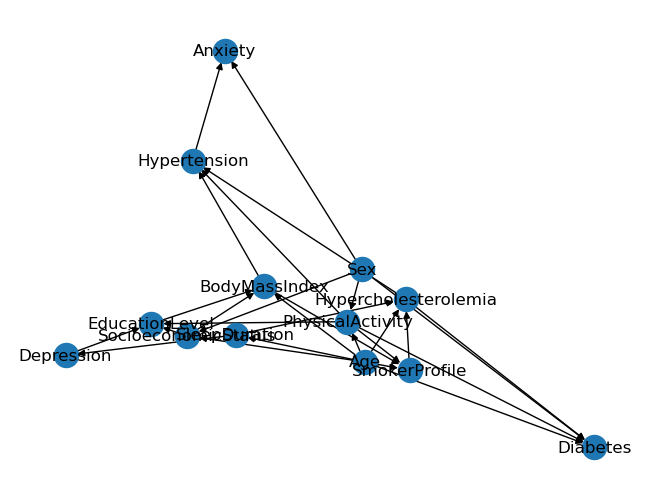

In [46]:
nx.draw(nx.DiGraph(current_model.edges()), with_labels=True)
plt.draw()